In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import wandb
import os
import torch.optim as optimizers
import dfs_code
from torch_geometric.data import InMemoryDataset, Data
import pickle
import torch
import torch.nn as nn
import tqdm
import copy
import pandas as pd
import torch.nn.functional as F
import sys
import yaml
import functools
from ml_collections import ConfigDict
sys.path = ['../../src'] + sys.path
from dfs_transformer import DFSCodeSeq2SeqFC, Deepchem2TorchGeometric, Trainer, to_cuda, Enzymes
from graphein.protein.resi_atoms import RESI_THREE_TO_1, AMINO_ACIDS

import random

2021-10-11 11:09:16.503701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt/lib:/opt/intel/tbb/lib:/opt/intel/clck/2019.0/lib:/opt/intel/compilers_and_libraries_2019/linux/lib:/opt/intel/compilers_and_libraries/linux/lib:/opt/intel/itac/2019.0.018/lib:/opt/intel/itac_2019/intel64/lib:/opt/intel/itac_latest/intel64/lib:/opt/intel/parallel_studio_xe_2019.0.045/clck_2019/lib:/opt/intel/parallel_studio_xe_2019.0.045/itac_2019/l

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install biovec.

To do so, use the following command:

    pip install biovec
To use the Graphein submodule graphein.protein.visualisation, you need to install pytorch3d.

pytorch3d cannot be installed via pip
To use the Graphein submodule graphein.protein.meshes, you need to install pytorch3d.

pytorch3d cannot be installed via pip


# download pretrained model

In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
run = wandb.init(mode="online", 
                 project="pubchem", 
                 entity="dfstransformer", 
                 job_type="inference")
model_at = run.use_artifact("bertloops0.3-10M-nofeats" + ":latest")
model_dir = model_at.download()
run.finish()
features = None# "chemprop"
n_molecules = 10
n_samples = 200
fingerprint = 'min-mean-max-std'
load_flag = True

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chrisxx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-10-11 11:09:19.281868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt

wandb: Downloading large artifact bertloops0.3-10M-nofeats:latest, 95.62MB. 2 files... Done. 0:0:0


In [5]:
with open(model_dir+"/config.yaml") as file:
    config = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [6]:
device = torch.device('cuda:%d'%config.training.gpu_id if torch.cuda.is_available()  else 'cpu')
device = 'cpu'

In [7]:
m = config.model

In [8]:
model = DFSCodeSeq2SeqFC(**m)
if load_flag:
    model.load_state_dict(torch.load(model_dir+'/checkpoint.pt', map_location=device))

In [9]:
model.to(device)

DFSCodeSeq2SeqFC(
  (encoder): DFSCodeEncoder(
    (emb_dfs): PositionalEncoding(
      (dropout): Dropout(p=0, inplace=False)
    )
    (emb_seq): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (emb_atom): Linear(in_features=118, out_features=120, bias=True)
    (emb_bond): Linear(in_features=5, out_features=120, bias=True)
    (mixer): Linear(in_features=600, out_features=600, bias=True)
    (enc): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=600, out_features=600, bias=True)
          )
          (linear1): Linear(in_features=600, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=600, bias=True)
          (norm1): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((600,), eps=1e-05, e

In [10]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("number of trainable parameters %d"%params)

number of trainable parameters 24697029


# load dataset

In [11]:
trainset = pd.read_csv("../../datasets/mymoleculenet/bbbp/0/train.csv")
train_X, train_y = trainset["smiles"].to_numpy(), trainset["target"].to_numpy()
traindata = Deepchem2TorchGeometric(train_X, train_y, loaddir="../../results/mymoleculenet_plus_features/bbbp/1/", features=features)

In [12]:
traindata = [d for d in traindata if d.edge_features.shape[0] == 40]

In [13]:
def collate_fn(dlist, n_samples=n_samples):
    node_batch = [] 
    edge_batch = []
    y_batch = []
    code_batch = []
    smiles = []
    
    for d in dlist:
        smiles += d.smiles 
        for _ in range(n_samples):
            edge_features = d.edge_features.clone()

            code, index = dfs_code.rnd_dfs_code_from_torch_geometric(d, d.z.numpy().tolist(), 
                                                                     np.argmax(d.edge_attr.numpy(), axis=1).tolist())

            code = torch.tensor(code, dtype=torch.long)
            index = torch.tensor(index, dtype=torch.long)
            code_batch += [code]
            node_batch += [d.node_features.clone()]
            edge_batch += [edge_features]
            y_batch += [d.y.clone()]
    y = torch.cat(y_batch).unsqueeze(1)
    return smiles, code_batch, node_batch, edge_batch, y

In [14]:
trainloader = DataLoader(traindata, batch_size=1, shuffle=False, pin_memory=False, 
                         collate_fn=collate_fn)

In [15]:
encodings = []
encodings2 = []
labels = []
dfs_codes = []
smiles = []
iterator = iter(trainloader)
for i in range(n_molecules):
    d = next(iterator)
    smiles += [d[0]]
    d = d[1:]
    d = [to_cuda(dd, device) for dd in d]
    encodings.append(model.encode(*d[:-1], fingerprint).detach().cpu().numpy())
    labels += len(d[0])*[i]
    dfs1, dfs2, atm1, atm2, bnd = model(*d[:-1])
    torch
    print(dfs1.shape)
    enc2 = torch.cat((dfs1.mean(dim=0), dfs2.mean(dim=0), atm1.mean(dim=0), atm2.mean(dim=0), bnd.mean(dim=0)), dim=1)
    encodings2.append(enc2.detach().cpu().numpy())
encodings = np.concatenate(encodings, axis=0)
encodings2 = np.concatenate(encodings2, axis=0)

torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])
torch.Size([20, 200, 250])


# sklearn kmeans benchmark

In [16]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [17]:
data = encodings.astype(np.float64)

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_molecules, n_init=4,
                random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_molecules, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_molecules).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_molecules, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.064s	3780230	0.572	0.578	0.575	0.348	0.571	0.051
random   	0.524s	3783479	0.571	0.584	0.577	0.351	0.574	0.052
PCA-based	0.272s	3835921	0.566	0.579	0.572	0.336	0.569	0.053
__________________________________________________________________________________


10K
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	3.851s	1299580	0.959	0.966	0.962	0.924	0.962	0.139
random   	2.292s	1305407	0.940	0.970	0.954	0.870	0.954	0.135
PCA-based	0.554s	1383451	0.896	0.927	0.911	0.802	0.910	0.103

100K init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.753s	1613620	0.873	0.874	0.874	0.835	0.871	0.066
random   	0.349s	1610052	0.740	0.763	0.751	0.606	0.746	0.075
PCA-based	0.165s	1645957	0.724	0.760	0.742	0.577	0.737	0.071

1M init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	5.437s	1489769	0.761	0.782	0.771	0.621	0.767	0.047
random   	3.327s	1493680	0.810	0.838	0.824	0.702	0.820	0.050
PCA-based	1.175s	1571641	0.736	0.754	0.745	0.575	0.740	0.031

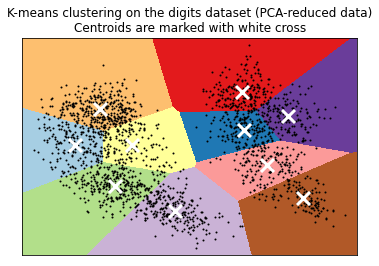

In [19]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_molecules, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [20]:
y = np.asarray(labels)

In [21]:
import matplotlib.colors as mcolors
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                 name)
                for name, color in mcolors.CSS4_COLORS.items())
names = [name for hsv, name in by_hsv]

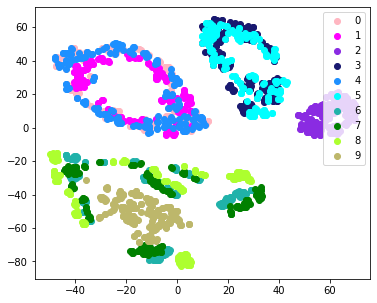

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(data)

target_ids = range(n_molecules)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
colors = names[::-1][0:10*n_molecules:10]
for i, c, label in zip(target_ids, colors, target_ids):
    #print(c)
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend(loc=1)
plt.show()

In [23]:
n_molecules

10

In [27]:
''.join(smiles[0])

'CCN(CC)CCNC(=O)c1cc(Cl)cc(Cl)c1OC'

In [28]:
''.join(smiles[4])

'CCN(CC)CCNC(=O)c1cc(Br)c(N)cc1OC'